In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import PIL
import tensorflow as tf
import os

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [1]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
dataset_path = os.listdir('drive/MyDrive/dataset')

face_types = os.listdir('drive/MyDrive/dataset')
print (face_types)  #what kinds of rooms are in this datase

['bishal', 'bishwa', 'isha']


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
face = []

for item in face_types:
 # Get all the file names
 all_rooms = os.listdir('drive/MyDrive/dataset' + '/' +item)
 #print(all_rooms)

 # Add them to the list
 for room in all_rooms:
    face.append((item, str('drive/MyDrive/dataset' + '/' +item) + '/' + room))
    #print(rooms[:3])


In [ ]:
img_height =224
img_width = 224
img_depth = 3
batch_size = 32

In [ ]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  "drive/MyDrive/dataset/",
  validation_split=0.8,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 938 files belonging to 3 classes.
Using 750 files for validation.


In [ ]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  "drive/MyDrive/dataset/",
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 938 files belonging to 3 classes.
Using 187 files for validation.


In [ ]:
class_names = train_ds.class_names
print(class_names)

['bishal', 'bishwa', 'isha']


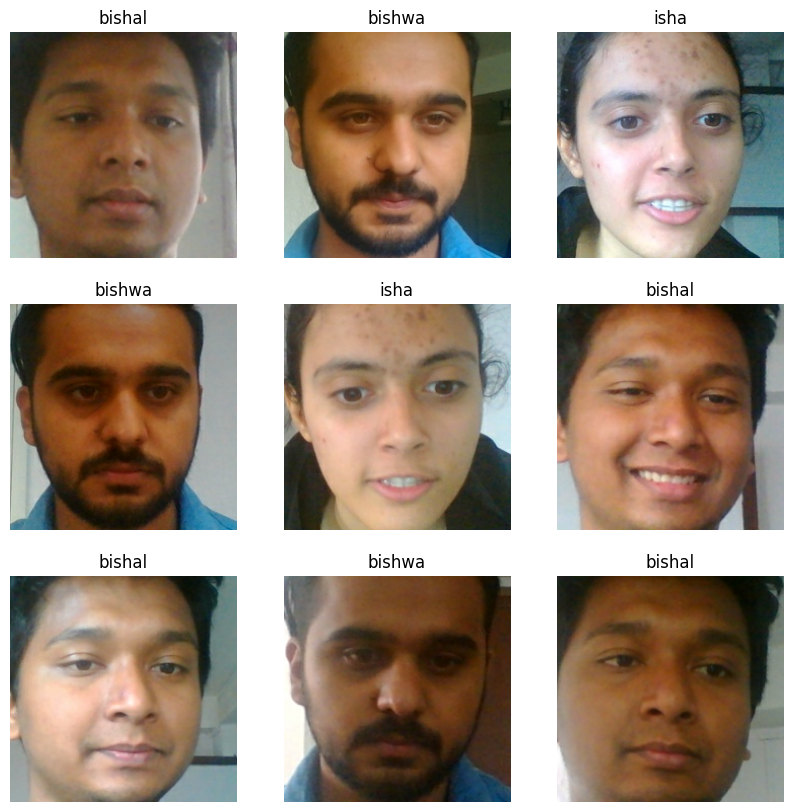

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [ ]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 224, 224, 3)
(32,)


In [ ]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [ ]:
normalization_layer = layers.Rescaling(1./255)

In [ ]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixel values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

0.027450982 1.0


In [ ]:
data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal",
                      input_shape=(img_height,
                                  img_width,
                                  3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
  ]
)

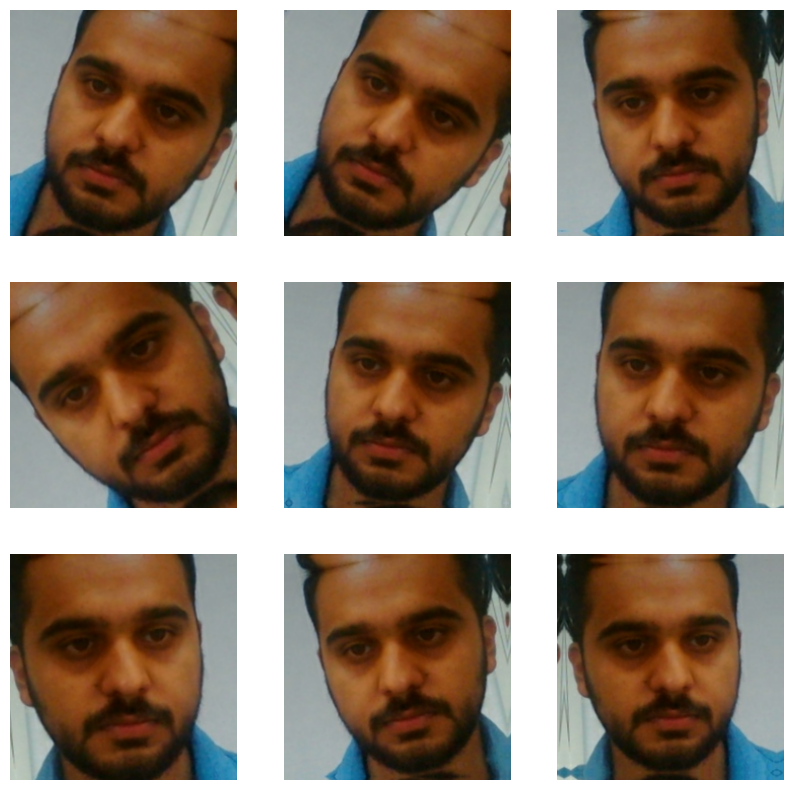

In [ ]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(9):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

In [ ]:
num_classes = len(class_names)
from keras.layers import Input, Conv2D, MaxPooling2D, Dense, Flatten , Dropout,BatchNormalization
from keras.models import Model
img_input = Input(shape=(224, 224, 3))
img_input = data_augmentation(img_input)

    
    # Block 1
x = Conv2D(64, (3, 3), activation='relu', padding='same', name='block1_conv1')(img_input)
x = Conv2D(64, (3, 3), activation='relu', padding='same', name='block1_conv2')(x)
x = MaxPooling2D((2, 2), strides=(2, 2), name='block1_pool')(x)

    # Block 2
x = Conv2D(128, (3, 3), activation='relu', padding='same', name='block2_conv1')(x)
x = Conv2D(128, (3, 3), activation='relu', padding='same', name='block2_conv2')(x)
x = MaxPooling2D((2, 2), strides=(2, 2), name='block2_pool')(x)

    # Block 3
x = Conv2D(256, (3, 3), activation='relu', padding='same', name='block3_conv1')(x)
x = Conv2D(256, (3, 3), activation='relu', padding='same', name='block3_conv2')(x)
x = Conv2D(256, (3, 3), activation='relu', padding='same', name='block3_conv3')(x)
x = MaxPooling2D((2, 2), strides=(2, 2), name='block3_pool')(x)

    # Block 4
x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block4_conv1')(x)
x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block4_conv2')(x)
x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block4_conv3')(x)
x = MaxPooling2D((2, 2), strides=(2, 2), name='block4_pool')(x)

    # Block 5
x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block5_conv1')(x)
x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block5_conv2')(x)
x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block5_conv3')(x)
x = MaxPooling2D((2, 2), strides=(2, 2), name='block5_pool')(x)

    
    # Classification block
x = Flatten(name='flatten')(x)
x = Dense(2048, activation='relu', name='fc1')(x)
x = BatchNormalization()(x)
x = Dropout(0.6)(x)
x = Dense(1024, activation='relu', name='fc2')(x)
x = BatchNormalization()(x)
x = Dropout(0.6)(x)
output = Dense(num_classes, activation='softmax', name='predictions')(x)

# Create the model by specifying the input and output tensors
model = Model(img_input, output)

In [ ]:
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [ ]:
epochs = 60
history = model.fit(
  train_ds, 
  validation_data=val_ds,
  epochs=epochs 
)

Epoch 1/60
24/24 [==============================] - 49s 860ms/step - loss: 0.7325 - accuracy: 0.7853 - val_loss: 74.5748 - val_accuracy: 0.3155
Epoch 2/60
24/24 [==============================] - 10s 407ms/step - loss: 0.4234 - accuracy: 0.9027 - val_loss: 108.2029 - val_accuracy: 0.3583
Epoch 3/60
24/24 [==============================] - 10s 408ms/step - loss: 0.0329 - accuracy: 0.9853 - val_loss: 0.3380 - val_accuracy: 0.9251
Epoch 4/60
24/24 [==============================] - 10s 407ms/step - loss: 0.0390 - accuracy: 0.9867 - val_loss: 341066.2500 - val_accuracy: 0.6257
Epoch 5/60
24/24 [==============================] - 10s 410ms/step - loss: 0.0312 - accuracy: 0.9933 - val_loss: 233856.5625 - val_accuracy: 0.3904
Epoch 6/60
24/24 [==============================] - 10s 410ms/step - loss: 0.0350 - accuracy: 0.9880 - val_loss: 62188.8359 - val_accuracy: 0.5134
Epoch 7/60
24/24 [==============================] - 10s 412ms/step - loss: 0.0373 - accuracy: 0.9880 - val_loss: 318081.2500 

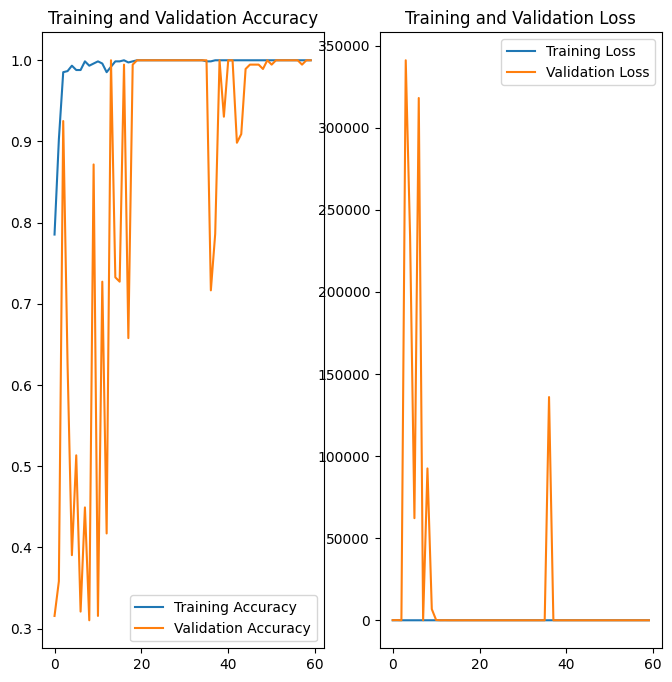

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show() 

In [ ]:
model.save("drive/MyDrive/Facedetetionmodel.h5")
model.save("drive/MyDrive/Facedetetionmodel.nn")

In [ ]:
def predict(image):
    img_path = image
    img = tf.keras.utils.load_img(
      img_path, target_size=(img_height, img_width)
    )
    img_array = tf.keras.utils.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0) # Create a batch
    
    predictions = model.predict(img_array)
    score = tf.nn.softmax(predictions[0])
    print("This image most likely belongs to {} with a {:.2f} percent confidence.".format(class_names[np.argmax(score)], 100 * np.max(score)))
    return class_names[np.argmax(score)]

In [ ]:
import cv2
from google.colab.patches import cv2_imshow

In [ ]:
from IPython.display import display, Javascript
from google.colab.output import eval_js
from base64 import b64decode

def take_photo(filename='photo.jpg', quality=0.8):
  js = Javascript('''
    async function takePhoto(quality) {
      const div = document.createElement('div');
      const capture = document.createElement('button');
      capture.textContent = 'Capture';
      div.appendChild(capture);

      const video = document.createElement('video');
      video.style.display = 'block';
      const stream = await navigator.mediaDevices.getUserMedia({video: true});

      document.body.appendChild(div);
      div.appendChild(video);
      video.srcObject = stream;
      await video.play();

      // Resize the output to fit the video element.
      google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

      // Wait for Capture to be clicked.
      await new Promise((resolve) => capture.onclick = resolve);

      const canvas = document.createElement('canvas');
      canvas.width = video.videoWidth;
      canvas.height = video.videoHeight;
      canvas.getContext('2d').drawImage(video, 0, 0);
      stream.getVideoTracks()[0].stop();
      div.remove();
      return canvas.toDataURL('image/jpeg', quality);
    }
    ''')
  display(js)
  data = eval_js('takePhoto({})'.format(quality))
  binary = b64decode(data.split(',')[1])
  with open(filename, 'wb') as f:
    f.write(binary)
  return filename

<IPython.core.display.Javascript object>

Saved to photo.jpg


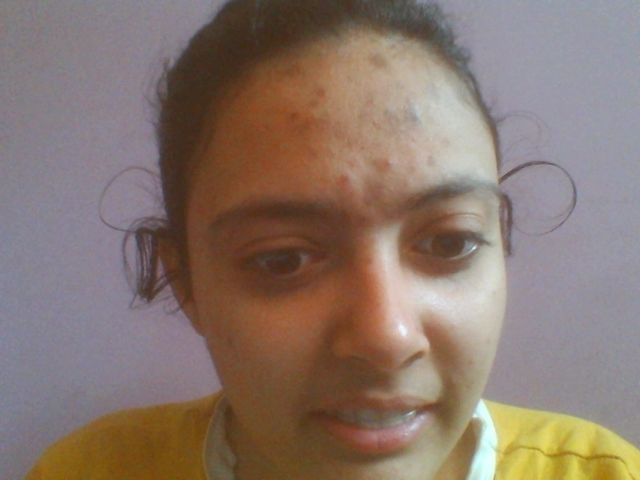

In [ ]:
from IPython.display import Image
try:
  filename = take_photo()
  print('Saved to {}'.format(filename))
  
  # Show the image which was just taken.
  display(Image(filename))
except Exception as err:
  # Errors will be thrown if the user does not have a webcam or if they do not
  # grant the page permission to access it.
  print(str(err))

In [ ]:
predict("photo.jpg")

1/1 [==============================] - 0s 21ms/step
This image most likely belongs to bishal with a 57.57 percent confidence.


'bishal'

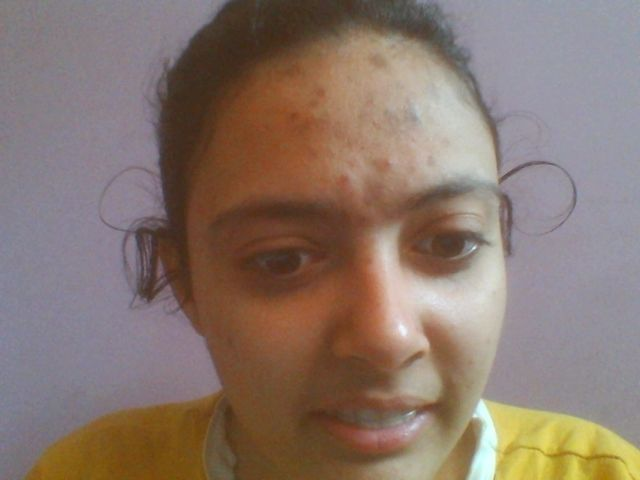

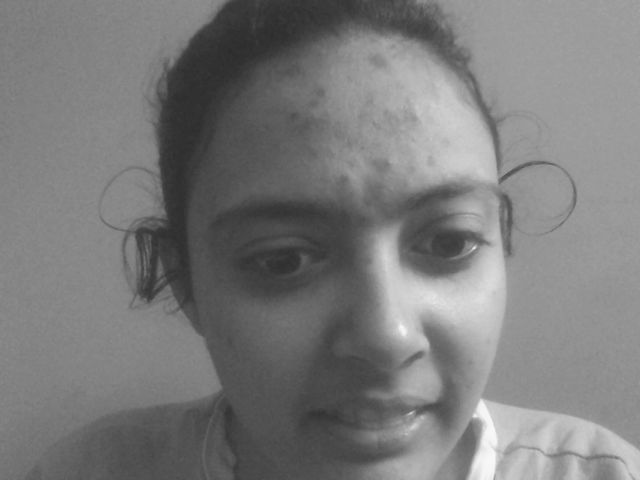

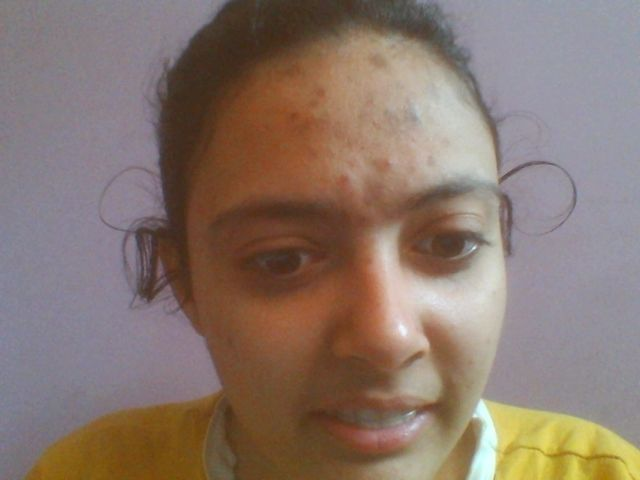

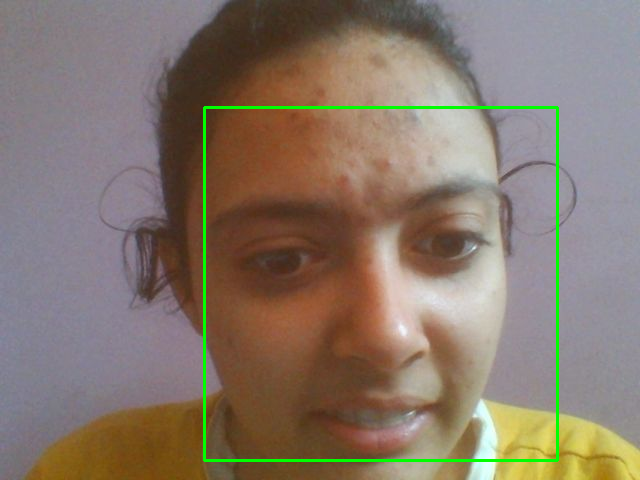

204


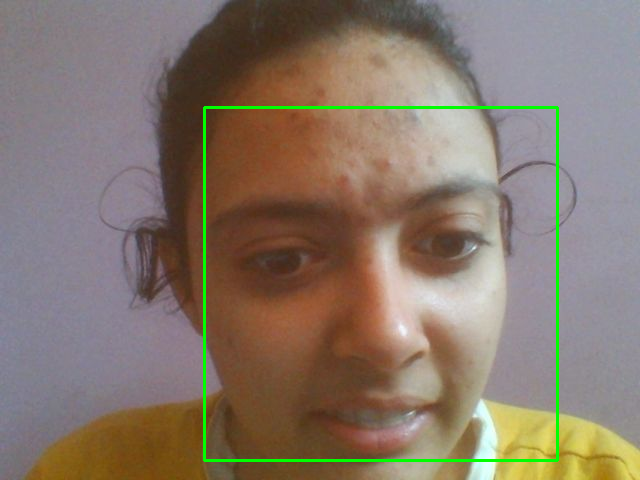

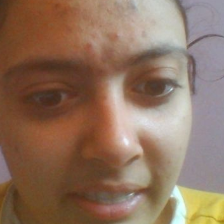

In [ ]:
import cv2
import os
from pathlib import Path
from google.colab.patches import cv2_imshow

def saveImage(image,crop):
    
    # Save the images inside the previously created folder
    x,y,w,h = crop
    imgcrop = image[y:h,x:w]
    imgcrop = cv2.resize(imgcrop,(224,224))
    cv2.imwrite("input.jpg", imgcrop)
    return imgcrop
    

faceCascade = cv2.CascadeClassifier("drive/MyDrive/haarcascade_frontalface_default.xml")
img = cv2.imread("photo.jpg")
orginal_img = img.copy()
cv2_imshow(img)
cv2.waitKey(0)
cv2.destroyAllWindows()

gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
cv2_imshow(gray_img)
cv2.waitKey(0)
cv2.destroyAllWindows()

faces = faceCascade.detectMultiScale(gray_img,scaleFactor=1.2,minNeighbors=5,minSize=(50, 50))

cv2_imshow(img)
for (x, y, w, h) in faces:
    cv2.rectangle(img, (x, y), (x + w, y + h), (0, 255, 0), 2)
    cv2_imshow(img)
    cv2.waitKey(0)
    cv2.destroyAllWindows() 
print(x)

cv2_imshow(img) 
img1 = saveImage(orginal_img,(x,y,x+w,y+w))
cv2_imshow(img1)   
cv2.waitKey(0)
cv2.destroyAllWindows()

In [ ]:
predict("input.jpg")

1/1 [==============================] - 0s 29ms/step
This image most likely belongs to isha with a 39.90 percent confidence.


'isha'

In [ ]:
newmodel =keras.models.load_model("drive/MyDrive/Facedetetionmodel.nn")

In [ ]:
def predict1(image):
    img_path = image
    img = tf.keras.utils.load_img(
      img_path, target_size=(img_height, img_width)
    )
    img_array = tf.keras.utils.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0) # Create a batch
    
    predictions = newmodel.predict(img_array)
    score = tf.nn.softmax(predictions[0])
    print("This image most likely belongs to {} with a {:.2f} percent confidence.".format(class_names[np.argmax(score)], 100 * np.max(score)))
    return class_names[np.argmax(score)]

In [ ]:
predict1("input.jpg")

1/1 [==============================] - 0s 181ms/step
This image most likely belongs to isha with a 39.90 percent confidence.


'isha'